# Algorithmic Fairness, Accountability, and Ethics, Spring 2024
# Exercise 3

## Task 0 (Setup)

We use the same dataset as in week 2. If you missed to install the module, please carry out the installation tasks at <https://github.com/zykls/folktables#basic-installation-instructions>.

After successful installation, you should be able to run the following code to generate a prediction task.
To make your life easier, we made the `BasicProblem`-magic from the `folktables` package (see exercises of week 2) explicit in this task.
This way, you can get access to different encodings of the data. 

**Note**: Some Windows users could not run the line `acs_data = data_source.get_data(states=["CA"], download=True)`. The dataset is available as a zip file on learnIT under week 2. Unzip it in the notebook's location, and set `download` to `False` in the code below.

In [2]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

# Task 1 (Logistic regression)

1) Train a logistic regression classifier on the training dataset. In our setup, the following parameters worked out well: `LogisticRegression(max_iter=5000, penalty = "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga")`. Which scaling considerations do you think are necessary?
2) Report on the accuracy of the model. (If you are interested: How is the classification accuracy on the original dataset with categorial input?)
3) Report on the model weights (sort them by weight). Which weights are most important? Explain the influence of the most important weights. (For example, "being female instead of male increases/decreases the odds for ... by ...".)
4) Find a negative or a positive instance, and discuss how you can use the weights discussion to create a counterfactual. (E.g., "By increasing/decreasing feature ... to ..., the person is classified as ...").

In [5]:
# logistc regression model
from sklearn.linear_model import LogisticRegression
print(X_train)
model = LogisticRegression(max_iter=5000, penalty = "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga")
model.fit(X_train, y_train)


        AGEP  HINS1_2  HINS2_2  HINS4_2  CIT_2  CIT_3  CIT_4  CIT_5  COW_2.0  \
358945    46    False     True     True  False  False  False  False     True   
275788    45    False     True     True  False  False  False  False    False   
141517    40    False     True     True  False  False   True  False    False   
66729     59    False     True     True  False  False   True  False    False   
268579    23    False    False     True  False  False  False  False    False   
...      ...      ...      ...      ...    ...    ...    ...    ...      ...   
296811    29    False     True     True  False  False  False  False    False   
343651    42    False     True     True  False  False  False  False    False   
231468    60    False     True     True  False  False  False  False    False   
337479    47    False     True     True  False  False  False  False    False   
89988     58    False     True     True  False  False  False  False    False   

        COW_3.0  ...  RAC1P_4  RAC1P_5 

LogisticRegression(C=0.8497534359086438, max_iter=5000, solver='saga')

In [8]:
print(X_train.columns)
print(X_train.head())
# print all numerical features


Index(['AGEP', 'HINS1_2', 'HINS2_2', 'HINS4_2', 'CIT_2', 'CIT_3', 'CIT_4',
       'CIT_5', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0',
       'COW_7.0', 'COW_8.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0',
       'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0',
       'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0',
       'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0',
       'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 'MAR_2', 'MAR_3',
       'MAR_4', 'MAR_5', 'SEX_2', 'RAC1P_2', 'RAC1P_3', 'RAC1P_4', 'RAC1P_5',
       'RAC1P_6', 'RAC1P_7', 'RAC1P_8', 'RAC1P_9', 'ENG_2.0', 'ENG_3.0',
       'ENG_4.0', 'ENG_nan'],
      dtype='object')
        AGEP  HINS1_2  HINS2_2  HINS4_2  CIT_2  CIT_3  CIT_4  CIT_5  COW_2.0  \
358945    46    False     True     True  False  False  False  False     True   
275788    45    False     True     True  False  False  False  False    False   
141517    40    False     True     True  Fals

1. Seems like data is mostly numeric, for one hot encoded features we could use a reference feature. I dont see an immediate candidate for reference feature so i will choose the most commonly occuring classsification as reference. Nvm I see he used drop first, I dont really like this but too lazy to fix.

In [9]:
acc = model.score(X_test, y_test)

acc_orig = model.score(X_train, y_train)

print(f"Accuracy on test set: {acc}")
print(f"Accuracy on train set: {acc_orig}")

Accuracy on test set: 0.769682876344773
Accuracy on train set: 0.769056806276033


2. Seems like model is not overfit (very surface level analysis), since training and test are both equally accurate.

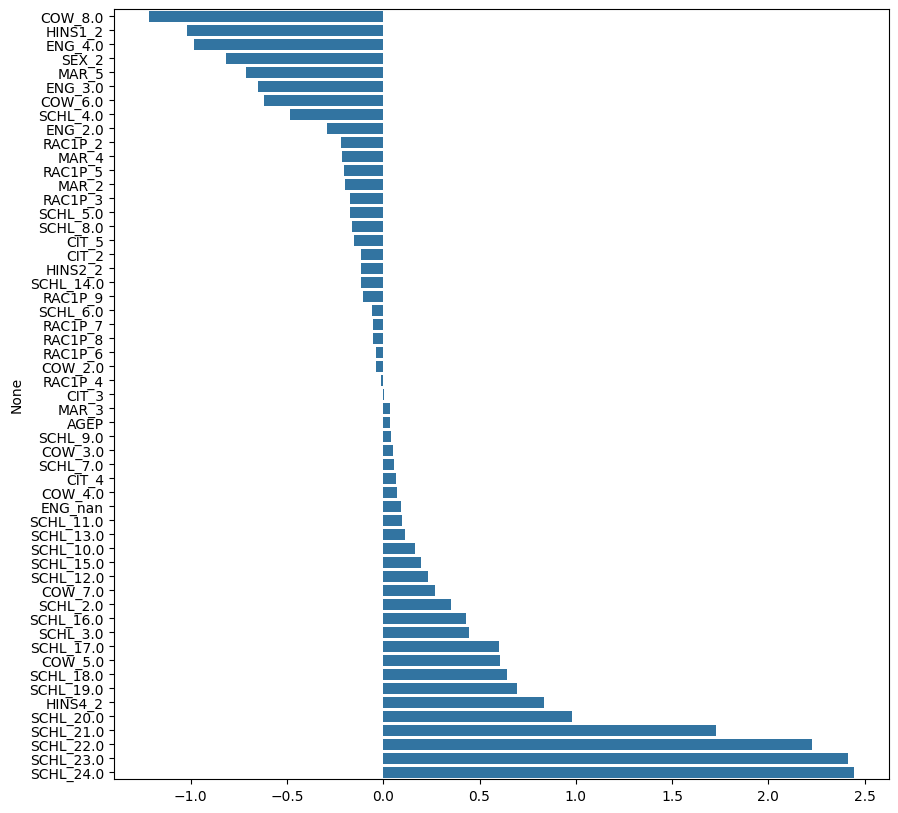

In [11]:
# get coefficients, sort them and plot them with the standard deviation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

coefs = model.coef_[0]
sorted_idx = np.argsort(coefs)
plt.figure(figsize=(10, 10))
sns.barplot(x=coefs[sorted_idx], y=X_train.columns[sorted_idx])
plt.show()



3. Seems like school has a the most importance, but since we have done a one hot encoding with the first column dropped as reference column, the importance is harder too interperet. 

# Task 2 (Decision tree)

1. Train a decision tree classifier on the training dataset. (You can work on the original dataset or on the one-hot encoded one.) The following parameter choices worked well in our setup: `(DecisionTreeClassifier(min_samples_split = 0.01, min_samples_leaf= 0.01, max_features="auto", max_depth = 15, criterion = "gini", random_state = 0))` Report on its accuracy. Visualize the tree using `plot_tree` from `sklearn`. Which parameters can you change the adapt the size of the tree? Try to find parameters that make the tree easier to understand.
2. For two training examples, explain their classification given the decision tree.
3. Compute feature importance as shown in the lecture. Which features are most important?
4. Provide a counterfactual, as in Task 2.


# Task 3 (Comparison)

Now you have both an interpretable logistic regression model and an interpretable decision tree model. Reflect on the explanations you can obtain from these two models: Do explanations from one model translate to the other? Do the counterfactuals from one work in the other model?  